In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set the image size for preprocessing
IMAGE_SIZE = (299, 299)

# Set the path to the dataset
DATASET_PATH = '/content/drive/MyDrive/AI Projecy/archive/dataset2'

# Set the seed for reproducibility
SEED = 49

In [3]:
# Import the necessary packages
import tensorflow as tf

# Create the training dataset from the images in the specified directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='training'
)

# Create the validation dataset from the images in the specified directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='validation'
)

Found 5778 files belonging to 8 classes.
Using 4045 files for training.
Found 5778 files belonging to 8 classes.
Using 1733 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['dew', 'fogsmog', 'glaze', 'hail', 'rain', 'rime', 'sandstorm', 'snow']

In [5]:
# Define a function to preprocess the images in the datasets
def process_image(img, lab):
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, lab

# Preprocess the images in the training dataset
train_ds = train_ds.map(process_image)

# Preprocess the images in the validation dataset
val_ds = val_ds.map(process_image)


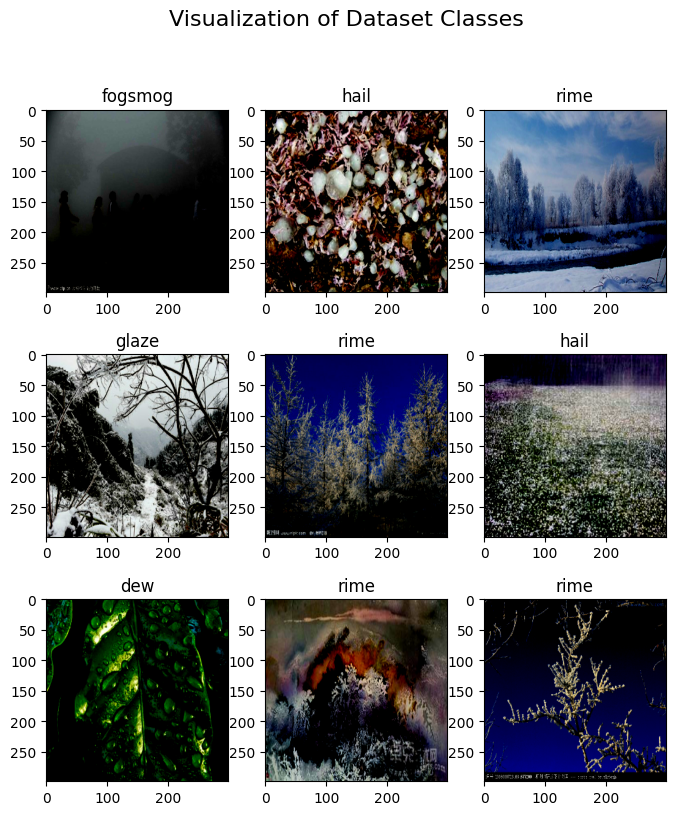

In [6]:
import matplotlib.pyplot as plt
# Define the size of the figure
plt.figure(figsize=(8, 9))

# Get the first batch of images and labels from the training dataset
for images, labels in train_ds.skip(5).take(1):
    # Iterate over the first 9 images and their labels
    for i, (img, lab) in enumerate(zip(images, labels)):
        if i >= 9:
            break
        # Plot the current image and its corresponding label
        plt.subplot(3, 3, i+1)
        # Convert the image and label to numpy arrays
        img = img.numpy()
        lab = lab.numpy()
        # Display the image and label as a title
        plt.imshow(img)
        plt.title(class_names[lab])

# Add a title to the figure
plt.suptitle('Visualization of Dataset Classes', fontsize=16)

# Display the figure
plt.show()

In [7]:
# Create the base Xception model
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet'
)

83683744/83683744 [==============================] - 1s 0us/step


In [8]:
# Print the input and output tensors of the model
print("Input Tensors:", base_model.inputs)
print("Output Tensors:", base_model.outputs)

Input Tensors: [<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]
Output Tensors: [<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>]


In [9]:
# Create a Global Average Pooling layer and connect it to the output of the base model
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.outputs[0])

# Create a Dense layer with softmax activation to output the predictions
num_classes = len(class_names)
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(gap_layer)

In [10]:
# Create the final model by connecting the base model inputs to the prediction layer
final_model = tf.keras.Model(inputs=base_model.inputs, outputs=prediction_layer)

# Print the model summary
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

## Training Upper Layers

In [11]:
# Set the base model as non-trainable
base_model.trainable = False

# Compile the final model with the appropriate loss, optimizer, and metrics
final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Define the necessary callbacks for the final model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint('xception_weather.h5', save_best_only=True)

In [13]:
# Train the final model using the training and validation datasets
history = final_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop, checkpoint])

Epoch 1/30
127/127 [==============================] - 524s 4s/step - loss: 0.9490 - accuracy: 0.7261 - val_loss: 0.5884 - val_accuracy: 0.8217
Epoch 2/30
127/127 [==============================] - 31s 240ms/step - loss: 0.5088 - accuracy: 0.8418 - val_loss: 0.4697 - val_accuracy: 0.8523
Epoch 3/30
127/127 [==============================] - 32s 245ms/step - loss: 0.4118 - accuracy: 0.8717 - val_loss: 0.4242 - val_accuracy: 0.8644
Epoch 4/30
127/127 [==============================] - 34s 257ms/step - loss: 0.3596 - accuracy: 0.8888 - val_loss: 0.3957 - val_accuracy: 0.8696
Epoch 5/30
127/127 [==============================] - 32s 244ms/step - loss: 0.3184 - accuracy: 0.9046 - val_loss: 0.3802 - val_accuracy: 0.8765
Epoch 6/30
127/127 [==============================] - 31s 240ms/step - loss: 0.2910 - accuracy: 0.9098 - val_loss: 0.3714 - val_accuracy: 0.8829
Epoch 7/30
127/127 [==============================] - 31s 239ms/step - loss: 0.2648 - accuracy: 0.9236 - val_loss: 0.3591 - val_accu

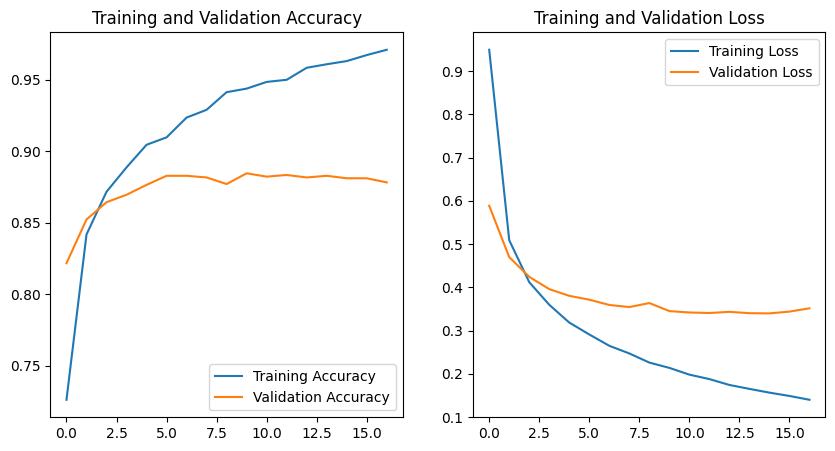

In [14]:
# Plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [15]:
# Set the base model as trainable
base_model.trainable = True

# Define the optimizer to use
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the final model with the updated optimizer and other parameters
final_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [16]:
# Train the updated final model using the training and validation datasets
history2 = final_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop, checkpoint])

Epoch 1/30
127/127 [==============================] - 78s 347ms/step - loss: 0.3710 - accuracy: 0.8677 - val_loss: 0.3485 - val_accuracy: 0.8863
Epoch 2/30
127/127 [==============================] - 46s 349ms/step - loss: 0.1890 - accuracy: 0.9466 - val_loss: 0.3363 - val_accuracy: 0.8857
Epoch 3/30
127/127 [==============================] - 45s 346ms/step - loss: 0.1217 - accuracy: 0.9671 - val_loss: 0.3283 - val_accuracy: 0.8909
Epoch 4/30
127/127 [==============================] - 58s 440ms/step - loss: 0.0849 - accuracy: 0.9824 - val_loss: 0.3161 - val_accuracy: 0.8944
Epoch 5/30
127/127 [==============================] - 47s 360ms/step - loss: 0.0682 - accuracy: 0.9869 - val_loss: 0.3099 - val_accuracy: 0.8967
Epoch 6/30
127/127 [==============================] - 47s 356ms/step - loss: 0.0456 - accuracy: 0.9931 - val_loss: 0.3017 - val_accuracy: 0.8990
Epoch 7/30
127/127 [==============================] - 46s 353ms/step - loss: 0.0358 - accuracy: 0.9968 - val_loss: 0.3005 - val_ac

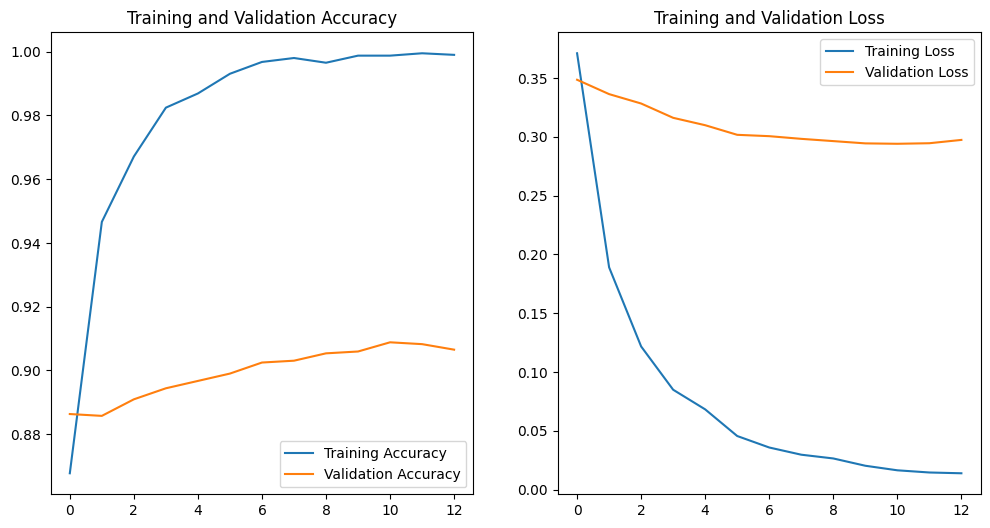

In [17]:
# Plot the training and validation accuracy/loss curves
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [18]:
final_model.save('./model')

In [19]:
# Create a tar archive of the model directory
!tar -cf ./model.tar ./model

# Remove the model directory
!rm -rf ./model

# Testing

In [20]:
import numpy as np
def predict(model, img_url, figsize=(3, 2)):
    # Download the image and convert it to a Numpy array
    file_path = tf.keras.utils.get_file(origin=img_url)
    img = tf.keras.utils.load_img(file_path, target_size=IMAGE_SIZE)
    img = np.asarray(img)

    # Preprocess the image and display it
    img, _ = process_image(img, '')
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

    # Reshape the image to match the model's input shape and make a prediction
    img = img.reshape([1, *IMAGE_SIZE, 3])
    pred = model.predict(img)

    # Show the predicted class label as the plot title
    ax.set_title(class_names[np.argmax(pred)])
    plt.show()

338169/338169 [==============================] - 0s 0us/step


1/1 [==============================] - 1s 1s/step


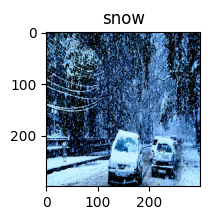

132575/132575 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 26ms/step


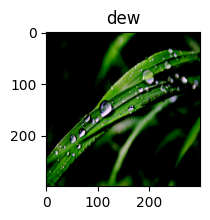

31974/31974 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 29ms/step


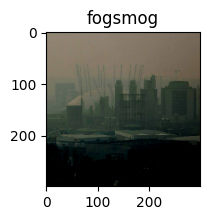

117716/117716 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 26ms/step


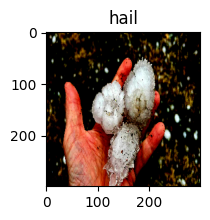

42419/42419 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 44ms/step


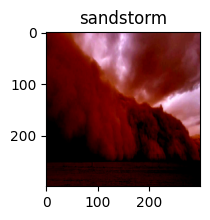

In [21]:
urls = [
    'https://gdb.voanews.com/0b4ced08-e1ae-465e-97ff-96ecfe8f0995_w1200_r1.jpg',
    'https://cdn.britannica.com/41/156341-050-7BBF1D54/Dew-grass.jpg',
    'https://ychef.files.bbci.co.uk/976x549/p03cpzc3.jpg',
    'https://dynaimage.cdn.cnn.com/cnn/c_fill,g_auto,w_1200,h_675,ar_16:9/https%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F230404170141-02-severe-weather-iowa-0404.jpg',
    'https://dynaimage.cdn.cnn.com/cnn/c_fill,g_auto,w_1200,h_675,ar_16:9/https%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F220721185605-china-sandstorm-cloud.jpg'
    
]

for url in urls:
    predict(final_model, url)

plt.show()

In [22]:

# Evaluate the model and print the accuracy and percentage
loss, accuracy = final_model.evaluate(val_ds)
percentage = accuracy * 100

print(f"Accuracy: {accuracy:.2f}")
print(f"Percentage: {percentage:.2f}%")

55/55 [==============================] - 11s 162ms/step - loss: 0.2974 - accuracy: 0.9065
Accuracy: 0.91
Percentage: 90.65%


1/1 [==============================] - 0s 31ms/step


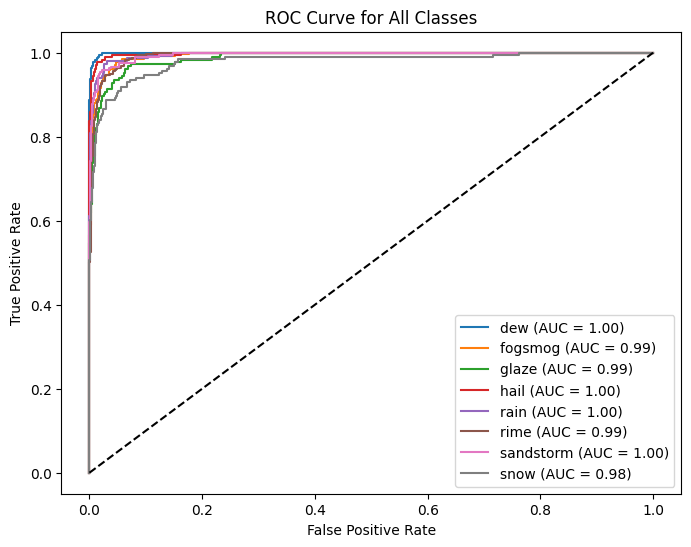

In [23]:
from sklearn.metrics import roc_curve, auc

# Get the true labels and predicted probabilities for the validation dataset
y_true = []
y_prob = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_prob.extend(final_model.predict(images).tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for all the classes
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Classes')
plt.legend()
plt.show()
